### Faster R-CNN Fine-Tuning Implementation Overview

This document describes the process of fine-tuning a pretrained Faster R-CNN model with a ResNet50 backbone for object detection tasks using a custom subset of the COCO dataset. The model is first loaded with pretrained weights, followed by fine-tuning on a user-defined subset of the dataset. The evaluation process uses standard COCO metrics to assess model performance. The goal is to experiment with various hyperparameters and modifications to improve detection results, and compare the fine-tuned model’s performance with that of the pretrained model.

Sources:
1) Paper: https://arxiv.org/pdf/1506.01497
2) Pytorch Documentation: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html


Note: Generative AI was used for coding assistance and debugging

### Run the consecutive code below for evaluation function

In [2]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import os
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [3]:
def load_model(checkpoint_path, device):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device), strict=False)
    model.to(device)
    model.eval()
    return model

In [4]:
def load_coco_dataset(coco_root):
    coco_annotations = f"{coco_root}/annotations/instances_val2017.json"
    coco_images = f"{coco_root}/val2017"
    coco = COCO(coco_annotations)
    return coco, coco_images

In [5]:
def calculate_iou(boxA, boxB):
    xA, yA, xB, yB = max(boxA[0], boxB[0]), max(boxA[1], boxB[1]), min(boxA[2], boxB[2]), min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea, boxBArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1]), (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea) if (boxAArea + boxBArea - interArea) > 0 else 0

In [6]:
def detect_objects(model, image_path, transform, device, score_threshold=0.5):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        predictions = model(image_tensor)[0]

    pred_boxes = predictions['boxes'].cpu().tolist()
    pred_classes = predictions['labels'].cpu().tolist()
    pred_scores = predictions['scores'].cpu().tolist()

    filtered_preds = [(box, cls, score) for box, cls, score in zip(pred_boxes, pred_classes, pred_scores) if score > score_threshold]

    if not filtered_preds:
        return ([], [], []) 

    return zip(*filtered_preds) if filtered_preds else ([], [], [])


In [ ]:
def evaluate_model(checkpoint_path, coco_root="/home/utn/abap44us/Desktop/fpg10/g10/mlp/coco2017", N=1000, iou_threshold=0.5, score_threshold=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = load_model(checkpoint_path, device)
    coco, coco_images = load_coco_dataset(coco_root)
    transform = transforms.Compose([transforms.ToTensor()])
    image_ids = coco.getImgIds()
    correct_detections, false_positives, false_negatives, total_predictions, total_ground_truth = 0, 0, 0, 0, 0
    coco_results, iou_scores, inference_times = [], [], []

    # Get the categories directly from the COCO dataset
    categories = coco.loadCats(coco.getCatIds())
    category_id_to_name = {cat['id']: cat['name'] for cat in categories}

    sample_image_ids = image_ids[:4]  
    plt.figure(figsize=(12, 12))  

    for i, img_id in enumerate(sample_image_ids):
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(coco_images, img_info['file_name'])
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get predictions for the image
        pred_boxes, pred_classes, pred_scores = detect_objects(model, img_path, transform, device, score_threshold)

        # Set label formatting parameters
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5  
        font_thickness = 1  
        color = (255, 0, 0)  
        bg_color = (255, 255, 255)  
        label_padding = 7  
        max_label_width = 250  

        # Draw bounding boxes on the image
        for box, cls in zip(pred_boxes, pred_classes):
            x1, y1, x2, y2 = map(int, box)
            label = category_id_to_name.get(cls, "Unknown")  

            # Format label text (no score)
            text = label

            # Resize text to fit within the max width
            text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
            label_width, label_height = text_size
            if label_width > max_label_width:
                font_scale *= max_label_width / label_width
                text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
                label_width, label_height = text_size

            label_rect = (x1, y1 - label_height - 2, x1 + label_width + 2, y1)

            # Draw background rectangle
            cv2.rectangle(image_rgb, (label_rect[0], label_rect[1]), (label_rect[2], label_rect[3]), bg_color, -1)
            # Draw bounding box rectangle
            cv2.rectangle(image_rgb, (x1, y1), (x2, y2), color, 2)  # Red bounding box
            # Draw label text
            cv2.putText(image_rgb, text, (x1 + label_padding, y1 - label_padding), font, font_scale, color, font_thickness)

        # Plot each image in a 2x2 grid
        plt.subplot(2, 2, i + 1)
        plt.imshow(image_rgb)
        plt.axis("off")
        plt.title(f"Image {img_id} Detections")

    plt.tight_layout()  # Adjust spacing for better layout
    plt.show()

    for img_id in image_ids[:N]:
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(coco_images, img_info['file_name'])
        annotations = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
        gt_boxes = [[x, y, x + w, y + h] for ann in annotations for x, y, w, h in [ann['bbox']]]
        start_time = time.time()
        pred_boxes, pred_classes, pred_scores = detect_objects(model, img_path, transform, device, score_threshold)
        end_time = time.time()
        inference_times.append(end_time - start_time)
        for box, cls, score in zip(pred_boxes, pred_classes, pred_scores):
            coco_results.append({"image_id": img_id, "category_id": cls, "bbox": [box[0], box[1], box[2] - box[0], box[3] - box[1]], "score": score})
        matched_gt_indices, true_positives, image_iou_scores = set(), 0, []
        for pred_box in pred_boxes:
            best_iou, best_gt_idx = 0, -1
            for gt_idx, gt_box in enumerate(gt_boxes):
                if gt_idx in matched_gt_indices:
                    continue
                iou = calculate_iou(pred_box, gt_box)
                if iou > best_iou:
                    best_iou, best_gt_idx = iou, gt_idx
            if best_iou >= iou_threshold and best_gt_idx != -1:
                true_positives += 1
                matched_gt_indices.add(best_gt_idx)
                image_iou_scores.append(best_iou)
            else:
                false_positives += 1
        false_negatives += len(gt_boxes) - len(matched_gt_indices)
        correct_detections += true_positives
        total_predictions += len(pred_boxes)
        total_ground_truth += len(gt_boxes)
        iou_scores.append(np.mean(image_iou_scores) if image_iou_scores else 0)
    
    precision = correct_detections / (correct_detections + false_positives) if (correct_detections + false_positives) > 0 else 0
    recall = correct_detections / (correct_detections + false_negatives) if (correct_detections + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    avg_iou_score = np.mean(iou_scores)
    avg_inference_time = np.mean(inference_times)
    
    coco_dt = coco.loadRes("coco_results.json")
    
    # Setting mAP to calculate for IoU thresholds 0.5 and 0.5:0.95
    coco_eval = COCOeval(coco, coco_dt, "bbox")
    coco_eval.params.iouThrs = np.linspace(0.5, 0.95, 10) 
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    
    map_05 = coco_eval.stats[0]  
    map_05_095 = coco_eval.stats[1] 
    
    print(f"Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1_score:.2f} | mAP@[0.5]: {map_05:.3f} | mAP@[0.5:0.95]: {map_05_095:.3f}")
    print(f"Avg IoU: {avg_iou_score:.3f} | Inference Time: {avg_inference_time:.4f}s")
    print(f"Total images evaluated: {len(image_ids[:N])}")


### Run all the consecutive code for training function

In [29]:
import time
import torch
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
from pycocotools.coco import COCO
from PIL import Image
import os
import torchvision
import random
from torchvision.ops import MultiScaleRoIAlign
import torch.nn as nn

In [30]:
# Define dataset paths
coco_root = "/home/utn/abap44us/Desktop/fpg10/g10/mlp/coco2017"
coco_train_annotations = f"{coco_root}/annotations/instances_train2017.json"
coco_train_images = f"{coco_root}/train2017"

In [ ]:
# Main modifications for the fasterrcnn resnet50
def initialize_model(model_name='fasterrcnn_resnet50_fpn'):
    print("Initializing the Faster R-CNN model...")
    if model_name == 'fasterrcnn_resnet50_fpn':
        model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    else:
        raise ValueError(f"Unsupported model name: {model_name}")

    # Set up anchor sizes and aspect ratios
    anchor_sizes = ((32), (64), (128), (256), (512))
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)

    # Update RPN anchor generator
    model.rpn.anchor_generator = torchvision.models.detection.rpn.AnchorGenerator(
        sizes=anchor_sizes, aspect_ratios=aspect_ratios
    )

    # Modify RoIAlign output size
    model.roi_heads.box_roi_pool = MultiScaleRoIAlign(
        featmap_names=["0", "1", "2", "3", "4"],
        output_size=7,
        sampling_ratio=2
    )

    # Freeze backbone and RPN layers
    for param in model.backbone.parameters():
        param.requires_grad = False
    for param in model.rpn.parameters():
        param.requires_grad = True

    return model

In [42]:
def create_dataloader(subset_size=100):
    print("Creating the DataLoader...")
    transform = transforms.Compose([transforms.ToTensor()])

    class COCODataset(torch.utils.data.Dataset):
        def __init__(self, coco, root, transform, subset_size=100, seed=42):
            self.coco = coco
            self.root = root
            self.transform = transform

            all_image_ids = coco.getImgIds()
            random.seed(seed)
            sampled_ids = random.sample(all_image_ids, subset_size)

            self.image_ids = []
            for img_id in sampled_ids:
                ann_ids = coco.getAnnIds(imgIds=img_id)
                if len(ann_ids) > 0:
                    self.image_ids.append(img_id)

            print(f"Subset: {len(self.image_ids)}/{subset_size} images have annotations.")
            if len(self.image_ids) == 0:
                raise ValueError("No valid images in subset!")

        def __len__(self):
            return len(self.image_ids)

        def __getitem__(self, idx):
            try:
                img_id = self.image_ids[idx]
                img_info = self.coco.loadImgs(img_id)[0]
                img_path = os.path.join(self.root, img_info['file_name'])

                image = Image.open(img_path).convert("RGB")
                image = self.transform(image)

                ann_ids = self.coco.getAnnIds(imgIds=img_id)
                anns = self.coco.loadAnns(ann_ids)

                assert len(anns) > 0, f"Image {img_id} has no annotations!"

                target = {}
                target['boxes'] = torch.tensor(
                    [[x, y, x + w, y + h] for ann in anns for x, y, w, h in [ann['bbox']]], 
                    dtype=torch.float32
                )
                target['labels'] = torch.tensor(
                    [ann['category_id'] for ann in anns],
                    dtype=torch.int64
                )
                return image, target
            except Exception as e:
                print(f"Error loading image {img_id}: {e}")
                dummy_image = torch.randn(3, 224, 224)
                dummy_target = {"boxes": torch.zeros(0, 4), "labels": torch.zeros(0)}
                return dummy_image, dummy_target

    coco = COCO(coco_train_annotations)
    dataset = COCODataset(coco, coco_train_images, transform, subset_size=subset_size)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

    return dataloader

In [41]:
def train_model(model, dataloader, num_epochs=10, learning_rate=0.0001):
    print("Starting the training process...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=learning_rate)

    epoch_times = []
    total_start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        epoch_start_time = time.time()

        for images, targets in dataloader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}, Time: {epoch_time:.2f} seconds")

    total_training_time = time.time() - total_start_time
    print(f"Total Training Time: {total_training_time:.2f} seconds")

In [45]:
# Main Wrapper Function to Call Everything
def train_faster_rcnn(model_name='fasterrcnn_resnet50_fpn', subset_size=100, num_epochs=10):
    model = initialize_model(model_name)
    dataloader = create_dataloader(subset_size)
    train_model(model, dataloader, num_epochs)

### Pretrain code: Pretrianed model RCNN Resnet 50

In [47]:
import torch
import torchvision

# Load a pretrained Faster R-CNN model
pretrained_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
pretrained_model.eval()  # Set model to evaluation mode

# Save the pretrained model's weights
pretrained_checkpoint_path = "pretrained_fasterrcnn.pth"
torch.save(pretrained_model.state_dict(), pretrained_checkpoint_path)
print(f"Pretrained Faster R-CNN model saved to {pretrained_checkpoint_path}")

Pretrained Faster R-CNN model saved to pretrained_fasterrcnn.pth


### Evaluation code: Pretrianed model RCNN Resnet 50

loading annotations into memory...
Done (t=0.99s)
creating index...
index created!


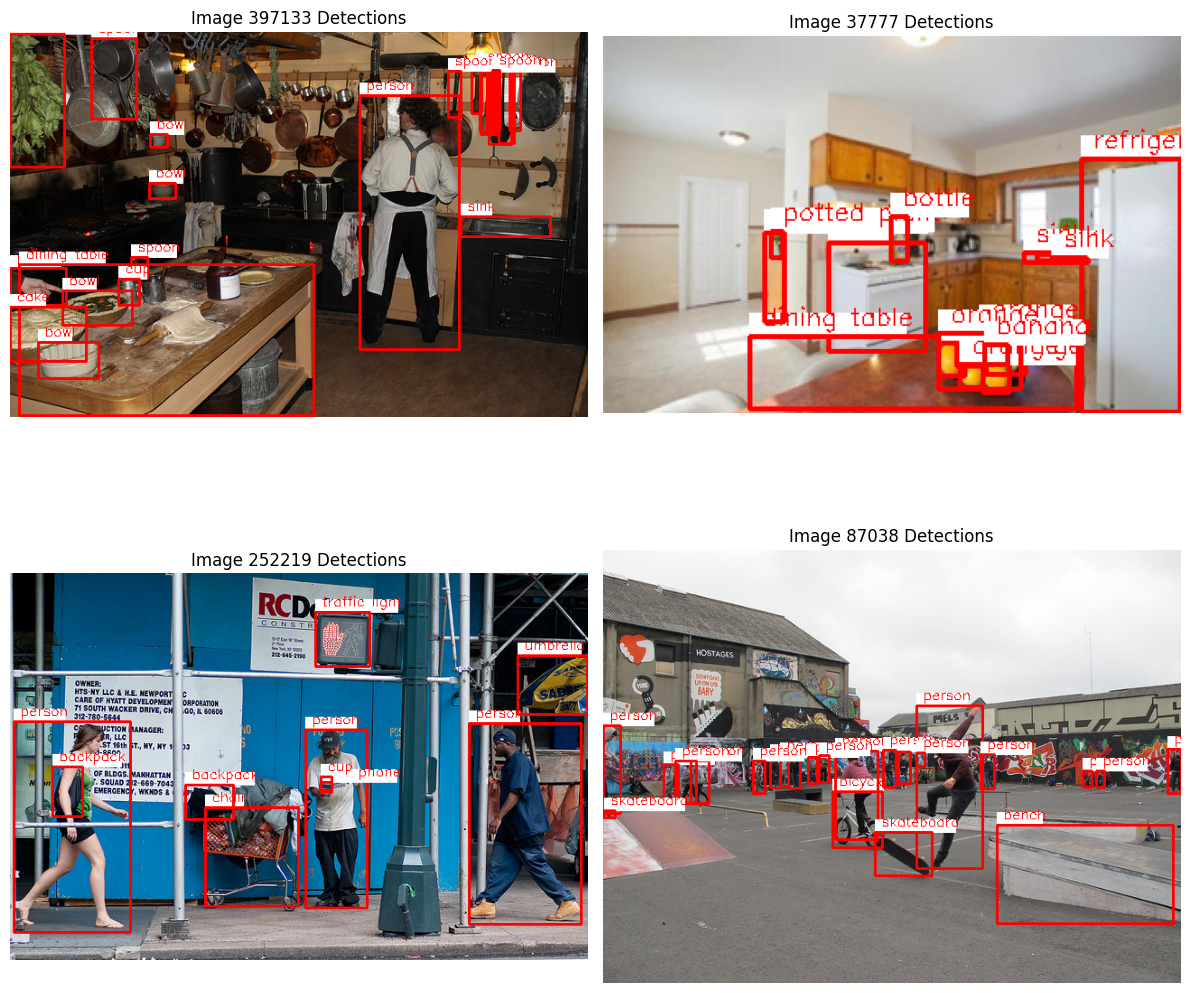

Loading and preparing results...
DONE (t=1.35s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=12.82s).
Accumulating evaluation results...
DONE (t=1.29s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.110
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.084
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.048
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.079
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

In [ ]:
evaluate_model(checkpoint_path="pretrained_fasterrcnn.pth")

### Retraining code: optimised RCNN model of 100 images

In [48]:

train_faster_rcnn(model_name='fasterrcnn_resnet50_fpn', subset_size=100)

Initializing the Faster R-CNN model...
Creating the DataLoader...
loading annotations into memory...
Done (t=27.03s)
creating index...
index created!
Subset: 100/100 images have annotations.
Starting the training process...
Epoch 1/10, Loss: 0.4845, Time: 11.58 seconds
Epoch 2/10, Loss: 0.4054, Time: 11.10 seconds
Epoch 3/10, Loss: 0.3425, Time: 9.08 seconds
Epoch 4/10, Loss: 0.3042, Time: 8.43 seconds
Epoch 5/10, Loss: 0.2884, Time: 10.44 seconds
Epoch 6/10, Loss: 0.2790, Time: 10.36 seconds
Epoch 7/10, Loss: 0.2619, Time: 9.63 seconds
Epoch 8/10, Loss: 0.2434, Time: 11.75 seconds
Epoch 9/10, Loss: 0.2380, Time: 10.75 seconds
Epoch 10/10, Loss: 0.2264, Time: 9.34 seconds
Total Training Time: 102.46 seconds


### Evaluation code: optimised RCNN model of 100 images

/home/utn/abap44us/Desktop/fpg10/g10/vit_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/utn/abap44us/Desktop/fpg10/g10/vit_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


loading annotations into memory...
Done (t=0.32s)
creating index...
index created!


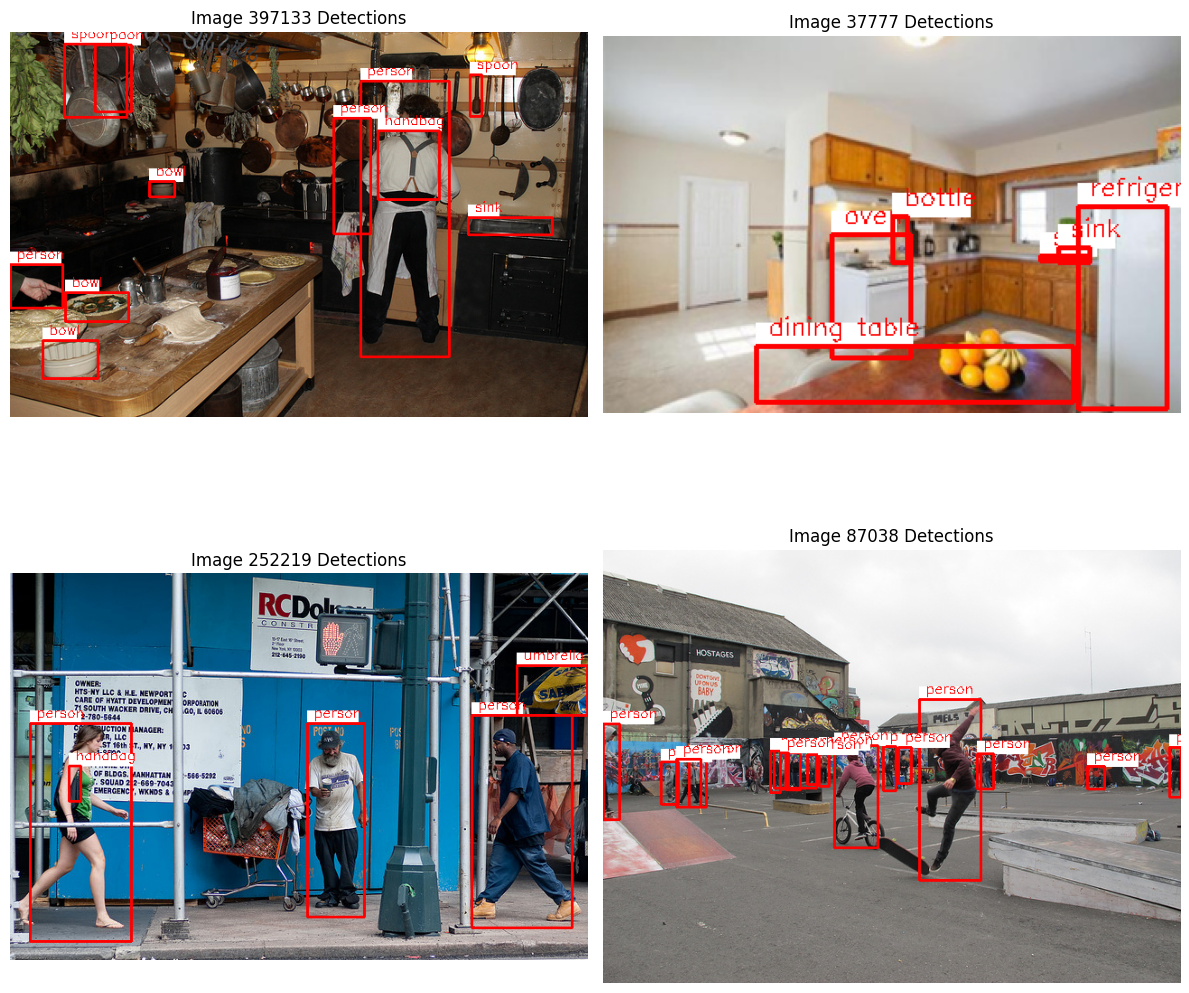

Loading and preparing results...
DONE (t=0.16s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.43s).
Accumulating evaluation results...
DONE (t=0.63s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.110
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.084
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.048
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.079
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [8]:
evaluate_model(checkpoint_path="faster_rcnn_roi_subset100.pth")

### Retraining code: optimised RCNN model of 1000 images

In [35]:
train_faster_rcnn(model_name='fasterrcnn_resnet50_fpn', subset_size=1000)

Initializing the Faster R-CNN model...
Creating the DataLoader...
loading annotations into memory...
Done (t=30.75s)
creating index...
index created!
Subset: 991/1000 images have annotations.
Starting the training process...
Epoch 1/10, Loss: 0.5019, Time: 92.87 seconds
Epoch 2/10, Loss: 0.4407, Time: 89.68 seconds
Epoch 3/10, Loss: 0.4099, Time: 91.07 seconds
Epoch 4/10, Loss: 0.3877, Time: 95.55 seconds
Epoch 5/10, Loss: 0.3688, Time: 103.60 seconds
Epoch 6/10, Loss: 0.3524, Time: 95.69 seconds
Epoch 7/10, Loss: 0.3378, Time: 98.38 seconds
Epoch 8/10, Loss: 0.3270, Time: 97.27 seconds
Epoch 9/10, Loss: 0.3192, Time: 97.90 seconds
Epoch 10/10, Loss: 0.3085, Time: 88.96 seconds
Total Training Time: 950.99 seconds


### Evaluation code: optimised RCNN model of 1000 images

In [ ]:
evaluate_model("fasterrcnn_resnet50_fpn_subset1000.pth")

### Retraining code: optimised RCNN model of 10000 images

In [ ]:
train_faster_rcnn(model_name='fasterrcnn_resnet50_fpn', subset_size=10000)

### Evaluation code: optimised RCNN model of 10000 images

loading annotations into memory...
Done (t=0.39s)
creating index...
index created!


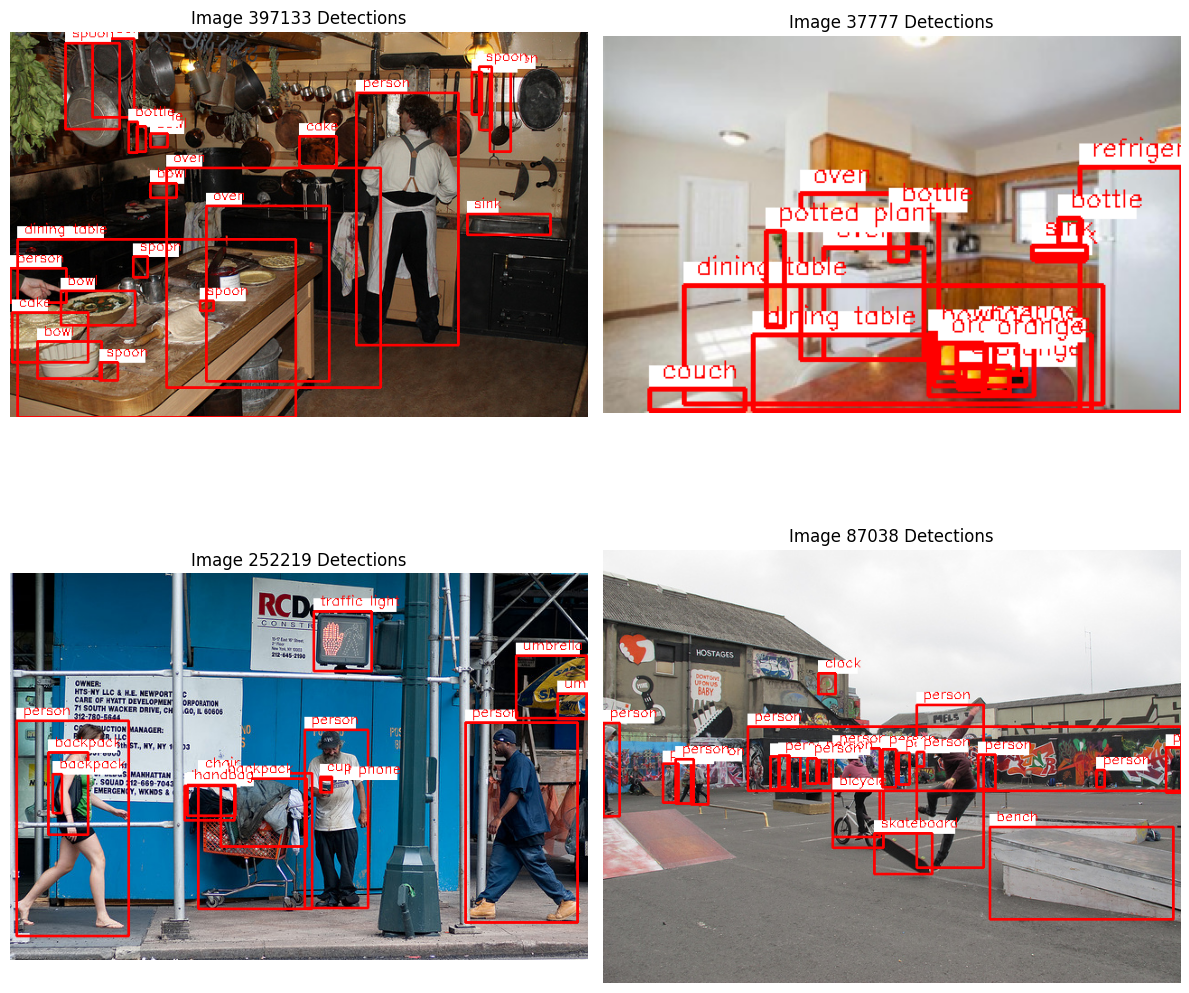

Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=16.89s).
Accumulating evaluation results...
DONE (t=1.35s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.110
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.084
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.048
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.079
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

In [50]:
evaluate_model(checkpoint_path="fasterrcnn_resnet50_fpn_subset10000.pth")